# 2) Importing the Libraries

In [1]:
import re
# import umap
import umap.umap_ as umap
import nltk
import hdbscan
import numpy as np
import pandas as pd
from string import *
import seaborn as sns
import transformers as ppb 
from keybert import KeyBERT
from collections import Counter
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer 
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rmaka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rmaka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3) Data Preparation

In [2]:
def prepare_data(stopwords):
    try: 
        df = pd.read_csv('data/raw_data.csv',encoding='ISO-8859-1')
    except Exception as e:
        print(str(e))

    df = df[['Title','Abstract']]
    df = df.dropna().drop_duplicates(subset=['Abstract'])
    df = df.dropna().drop_duplicates(subset=['Title'])
    df['Abstract'] = df['Abstract'].apply(remove_stop_lemmatize, args=(stopwords,))
    df = df[df['Abstract'].str.len() > 150].reset_index()
    df['index']    = df.index
    df['abstract_list'] =  df['Abstract'].apply(lambda x : x.split(' '))
    df['abstract_list_len'] =  df['abstract_list'].apply(lambda x : len(x))
    df['abstract_list_trunc'] =  df['abstract_list'].apply(lambda x : x[0:400])
    df['aabstract_list_trunc_len'] =  df['abstract_list_trunc'].apply(lambda x : len(x))
    df['final_text'] = df['abstract_list_trunc'].apply(lambda x : ' '.join(x))
    return df

def remove_stop_lemmatize(text, stopwords):
    text = text.replace('-',' ')
    text = re.sub (r'([^a-zA-Z ]+?)', '', text)
    if stopwords:
        text = text.split(' ')
        return ' '.join(lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words)
    else:
        return text

In [3]:
n_data = prepare_data(stopwords=False)

# 4) EDA

Text(0.5, 1.0, 'Data Size distribution of Raw Data')

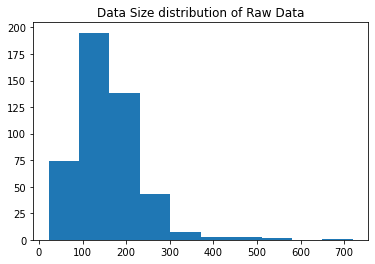

In [4]:
plt.hist(n_data['abstract_list_len'])
plt.title('Data Size distribution of Raw Data')

Text(0.5, 1.0, 'Data Size distribution of Processed Data')

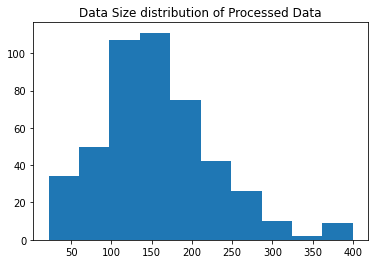

In [5]:
plt.hist(n_data['aabstract_list_trunc_len'])
plt.title('Data Size distribution of Processed Data')

# 5) Cosine SImilarity-

In [6]:
def create_similarity_heatmap(corpus_embeddings):
  similarity_matrix = cosine_similarity(corpus_embeddings)
  sns.set(font_scale=1)
  f, ax = plt.subplots(figsize=(11, 9))
  c = sns.heatmap(similarity_matrix, square=True,  ax=ax)
  c.set(xlabel='Document ID', ylabel='Document ID')
  plt.show()
  fig = c.get_figure()
  fig.suptitle('TF-IDF Document Similarity Matrix', fontsize=25)

# 6) Clustering 

## 6.a) Elbow Plot

In [7]:
def plot_elbow_method(embedding):
  
  Sum_of_squared_distances = []
  K = range(1,15)
  for k in K:
      km = KMeans(n_clusters=k)
      km = km.fit(embedding)
      Sum_of_squared_distances.append(km.inertia_)
  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

## 6.b) PCA and Kmeans

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def get_cluster_kmeans(vectorize, num_clusters, r_state=100):
    km = KMeans(n_clusters = num_clusters, random_state=r_state )
    km.fit(vectorize)
    cluster_list = km.labels_.tolist()
    return cluster_list

def pca_reduction(similarity_matrix, n_components):
    one_min_sim = 1 - similarity_matrix #why substraction?
    pca = PCA(n_components=10)
    pos = pca.fit_transform(one_min_sim)
    x_pos, y_pos = pos[:, 0], pos[:, 1]
    return (x_pos, y_pos)


## 6.c) TSNE Implementation

In [9]:
def produce_tsne(embedding ,clusters ,n_components, perplexity, n_iter, learning_rate):
    df_embedding = pd.DataFrame(embedding)
    tsne_results = None
    tsne_results = TSNE(n_components=n_components, 
                      perplexity=perplexity, 
                      n_iter=300,
                      learning_rate = learning_rate
                      ).fit_transform(df_embedding)
  
    df_embedding['tsne-2d-one'] = tsne_results[:,0]
    df_embedding['tsne-2d-two'] = tsne_results[:,1]
    df_embedding['y']           = clusters
    plt.figure(figsize=(10,10))
    sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue="y",
      palette='Spectral',
      data=df_embedding,
      legend="full"
  )

## 6.d) DBSCAN

In [10]:
def get_dbscan_cluster(umap_data, epsilon, min_s = 3):
    db = DBSCAN(eps= epsilon, min_samples= min_s).fit(umap_data)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    #n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    return labels

## 6.e) HDB Scan

In [11]:
def hdbscan_cluster(metric, 
                    umap_data,
                    min_samples, 
                    min_cluster_size, 
                    cluster_selection_method,
                    cluster_selection_epsilon
                    ):
  cluster = hdbscan.HDBSCAN(min_cluster_size          = min_cluster_size,
                            metric                    = metric,                  
                            min_samples               = min_samples, 
                            cluster_selection_epsilon = cluster_selection_epsilon,
                            cluster_selection_method  = cluster_selection_method, 
                            gen_min_span_tree         = True
                            ).fit(umap_data)
                      
  return cluster

## 6.f) UMAP

In [12]:
def create_umap_data(embedding,
                       n_components, 
                       n_neighbors, 
                       learning_rate, 
                       min_dist,
                     metric):
  
    umap_data = umap.UMAP(n_neighbors   = n_neighbors, 
                            metric        = metric,
                            min_dist      = min_dist, 
                            n_components  = n_components, 
                            learning_rate = learning_rate,
                            ).fit_transform(embedding)

    return umap_data

## 6.g) Plotting Scatter plot -2D

In [13]:
def plot_graph(clusters, umap_data):
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters
    plt.figure(figsize=(10,10))
    sns.scatterplot(
                    x="x", y="y",
                    hue="labels",
                    palette='Spectral',
                    data=result,
                    legend="full"
  )

# 7) Mean S-BERT Encode 

## 7.a) Initiating the model

In [14]:
from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for
# sentences = list(n_data['final_text'].values) 

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")

#Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=300, return_tensors='pt')

# #Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# #Perform pooling. In this case, mean pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [17]:
import csv
import os.path
from os import path
if not path.exists("data/s_bert.csv"):
    with open('data/s_bert.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        for sentence in n_data['final_text'].values:
            encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=450, return_tensors='pt')
            with torch.no_grad():
                model_output = model(**encoded_input)
            writer.writerow(mean_pooling(model_output, encoded_input['attention_mask']))

In [18]:
df_sbert = pd.read_csv('data/s_bert.csv',header=None)

In [19]:
s_bert_list =[]
for i in df_sbert[0]:
    s_bert_list.append([float(j) for j in i.replace('\n','').replace('tensor(','').replace(')','').replace('[','').replace(']','').split(',')])

In [20]:
sentence_embeddings_df = pd.DataFrame(s_bert_list)

In [21]:
sentence_embeddings = np.array(sentence_embeddings_df)

## 7.d) Plotting the similarity Matrix

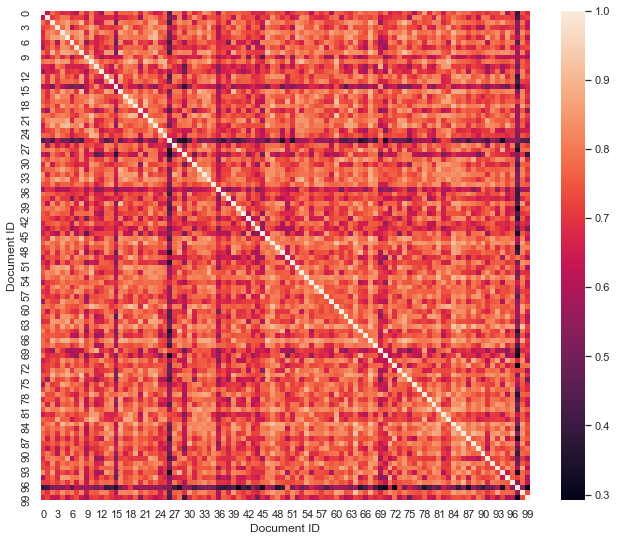

In [22]:
create_similarity_heatmap(sentence_embeddings[100:200,100:200])

## 7.e) KMeans Implementation

### Elbow Method to estimate # of  clusters

C:\Users\rmaka\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


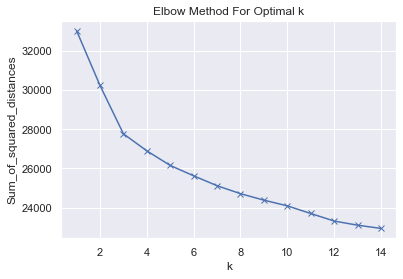

In [23]:
plot_elbow_method(sentence_embeddings)

### PCA plot with KMEANS

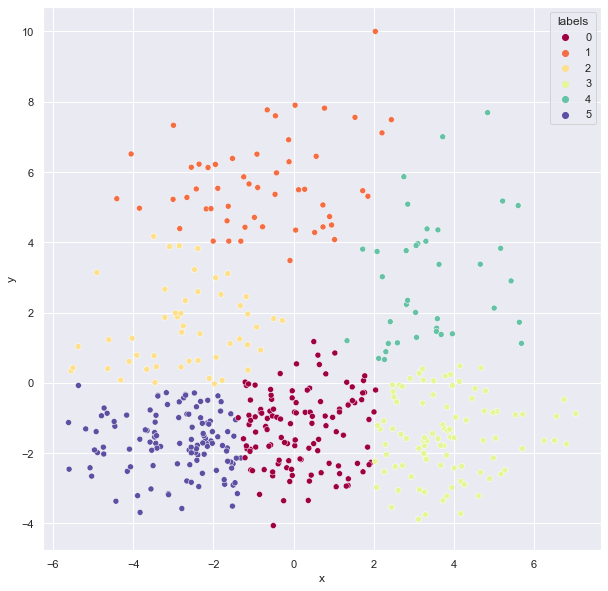

In [24]:
number_of_clusters = 6
x_pos, y_pos = pca_reduction(sentence_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_s_bert = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_s_bert, df)

In [25]:
### TSNE plot with KMEANS

### TSNE plot with KMEANS

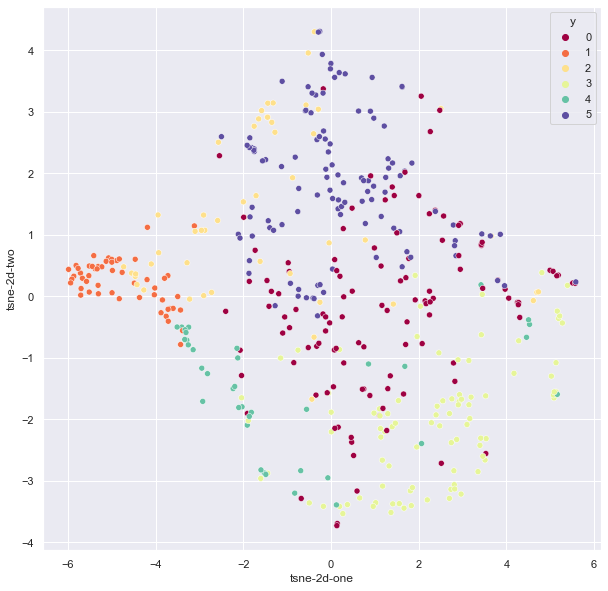

In [38]:
produce_tsne(embedding =  sentence_embeddings,
             clusters = km_clusters_s_bert,
             n_components = 2, 
             perplexity = 5, 
             n_iter = 3000, 
             learning_rate=3)

## 7.f) DBSCAN Implementation

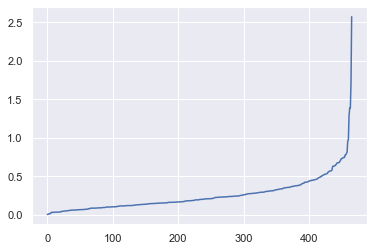

In [22]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [23]:
import umap.umap_ as umap

In [24]:
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
# adjusted_rand_score(km_clusters_s_bert, db_scan_cluster_sbert)

# hyperparameter optimisation
from hyperopt import fmin, hp, tpe

space = {
    'n_neighbors': hp.quniform("n_neighbors", 2, 10, 1),
    'min_dist': hp.uniform('min_dist',0.001, 0.1),
    # 'epsilon': hp.uniform('epsilon', 0.0001, 1)
}

def objective_function(space):
  # we take the cluster assinged in k-means as truth and try to optimise our values for dbscan to maximise the match
    print('Trying with values', str(space))
    umap_data = create_umap_data(embedding = sentence_embeddings,
                                          n_components = 2, 
                                          n_neighbors = int(space['n_neighbors']) , 
                                          min_dist = space['min_dist'],
                                          learning_rate = 10,
                                            metric = 'cosine')
    db_scan_cluster_sbert = get_dbscan_cluster(umap_data = umap_data, epsilon=0.3, min_s = 3)
    print(- silhouette_score(umap_data, db_scan_cluster_sbert))
    return - silhouette_score(umap_data, db_scan_cluster_sbert)

best = fmin(fn=objective_function,
            space=space,
            algo=tpe.suggest,
            max_evals=25)

print(best)

Trying with values                                                                                                     
{'min_dist': 0.08983540046273095, 'n_neighbors': 5.0}                                                                  
-0.08002382                                                                                                            
Trying with values                                                                                                     
{'min_dist': 0.011483619179306858, 'n_neighbors': 5.0}                                                                 
-0.2834356                                                                                                             
Trying with values                                                                                                     
{'min_dist': 0.09503891092294624, 'n_neighbors': 8.0}                                                                  
-0.25102207                             

In [25]:
def plot_bar(clusters):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  cluster = list(set(clusters))
  cluster_count = []
  for i in cluster:
    count = 0
    for j in clusters:
      if i == j:
        count = count + 1
    cluster_count.append(count)

  # cluster_count = [23,17,35,29,12]
  plt.xticks(np.arange(min(clusters), max(clusters)+1, 1.0))
  ax.bar(cluster,cluster_count)
  plt.show()

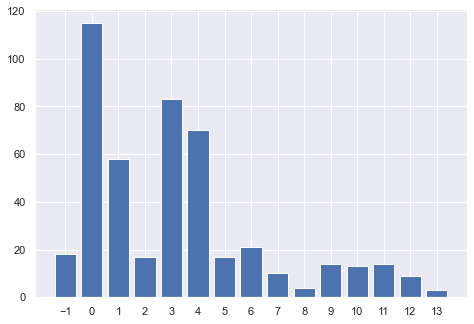

In [38]:
umap_data_db_scan = create_umap_data( embedding     = sentence_embeddings,
                                      n_neighbors   = 8,
                                      n_components  = 2,
                                      learning_rate = 10,
                                      min_dist      = 0.023,
                                      metric        ='cosine')

db_s_bert_cluster = get_dbscan_cluster(
    umap_data = umap_data_db_scan,
    epsilon = 0.30
)
plot_bar(db_s_bert_cluster)

In [39]:
silhouette_score(umap_data_db_scan, db_s_bert_cluster)

0.25057527

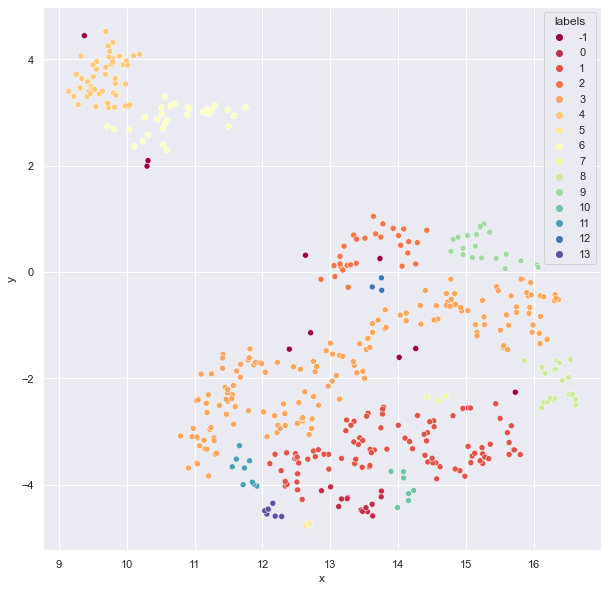

In [28]:
plot_graph(clusters=db_s_bert_cluster, umap_data=umap_data_db_scan)

## 7.g) HDB Scan Implementation

In [29]:
from sklearn.metrics.cluster import adjusted_rand_score
# adjusted_rand_score(km_clusters_s_bert, db_scan_cluster_sbert)

# hyperparameter optimisation
from hyperopt import fmin, hp, tpe

space = {
    'n_neighbors': hp.quniform("n_neighbors", 2, 20, 1),
    'min_cluster_size': hp.quniform("min_cluster_size", 2, 20, 1),
    'min_dist': hp.uniform('min_dist',0.001, 0.1),
    'cluster_selection_epsilon': hp.uniform('cluster_selection_epsilon', 0.01, 0.7)
}

def objective_function(space):
  # we take the cluster assinged in k-means as truth and try to optimise our values for dbscan to maximise the match
  print('Trying with values', str(space))
  umap_data = create_umap_data(embedding = sentence_embeddings,
                                          n_components = 2, 
                                          n_neighbors = int(space['n_neighbors']) , 
                                          min_dist = space['min_dist'],
                                          learning_rate = 10,
                                            metric = 'cosine')
  hdb_cluster_s_bert = hdbscan_cluster(umap_data=umap_data,
                          min_cluster_size=int(space['min_cluster_size']),
                          min_samples = 1, 
                          cluster_selection_epsilon = 0.3,
                          metric = 'cityblock',                  
                          cluster_selection_method='leaf'
                          )
  print(- silhouette_score(umap_data, hdb_cluster_s_bert.labels_))
  return - silhouette_score(umap_data, hdb_cluster_s_bert.labels_)

best = fmin(fn=objective_function,
            space=space,
            algo=tpe.suggest,
            max_evals=25)

print(best)

Trying with values                                                                                                     
{'cluster_selection_epsilon': 0.2498397278696134, 'min_cluster_size': 16.0, 'min_dist': 0.044542536585065885, 'n_neighbors': 5.0}
-0.2943843                                                                                                             
Trying with values                                                                                                     
{'cluster_selection_epsilon': 0.44444849582287754, 'min_cluster_size': 7.0, 'min_dist': 0.031829659691185425, 'n_neighbors': 8.0}
-0.2577181                                                                                                             
Trying with values                                                                                                     
{'cluster_selection_epsilon': 0.19682937053408908, 'min_cluster_size': 9.0, 'min_dist': 0.04422466687471024, 'n_neighbors': 18.0}
-0.2946992

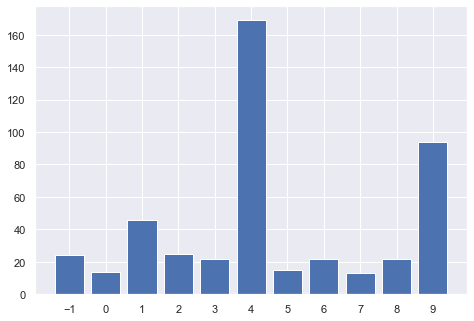

In [30]:

umap_data_hdb_scan = create_umap_data( embedding     = sentence_embeddings,
                                      n_neighbors   = 5,
                                      n_components  = 2,
                                      learning_rate = 1,
                                      min_dist      = 0.077,
                                      metric        ='cosine')

hdb_cluster_s_bert = hdbscan_cluster(umap_data=umap_data_hdb_scan,
                          min_cluster_size=12,
                          min_samples = 1, 
                          cluster_selection_epsilon = 0.4,
                          metric = 'cityblock',                  
                          cluster_selection_method='leaf'
                          )

plot_bar(hdb_cluster_s_bert.labels_)

<AxesSubplot:ylabel='$\\lambda$ value'>

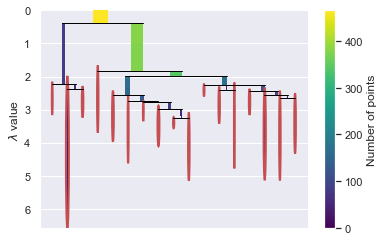

In [31]:
hdb_cluster_s_bert.condensed_tree_.plot(select_clusters=True)

In [32]:
silhouette_score(umap_data_hdb_scan, hdb_cluster_s_bert.labels_)

0.20717716

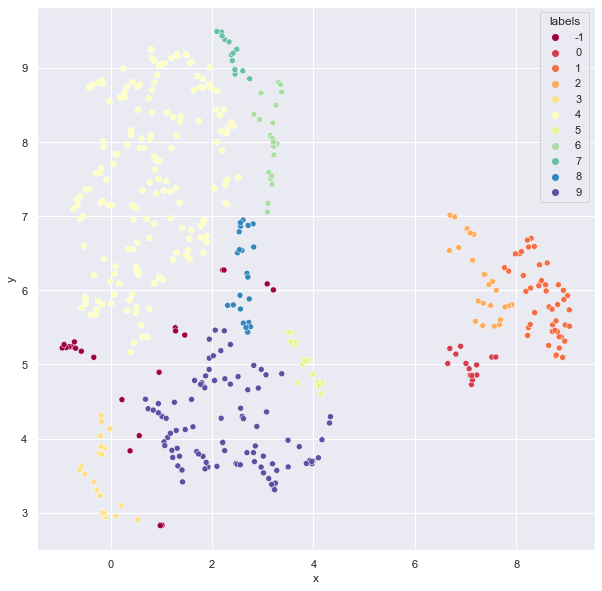

In [33]:
plot_graph(clusters=hdb_cluster_s_bert.labels_, umap_data=umap_data_hdb_scan)